# HW 30

In [1]:
# import jax
# import jax.numpy as jnp
import numpy as np
import pandas as pd
# import PIL
# import scipy
import sympy as sp
from matplotlib import pyplot as plt
from scipy.optimize import minimize

<img src="fig_30_intro.png" alt="formula" width="900">

In [2]:
def f(a, xk, b, uk):
    return a*xk+b*uk


<img src="fig_30_a.png" alt="formula" width="900">

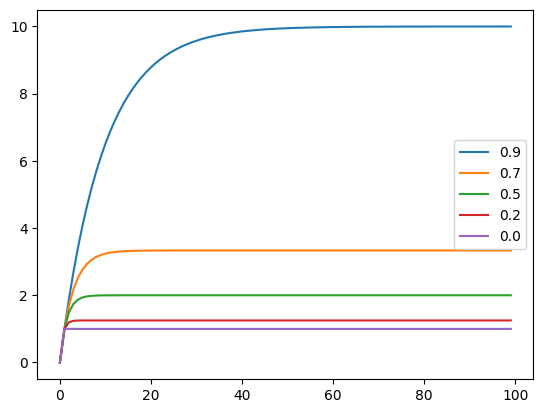

In [3]:
x0 = 0
# u0 = 0
# uk = 1
b = 1
k_multi = np.linspace(0, 99, 100)
a_multi = np.array([0.9, 0.7, 0.5, 0.2, 0])

for a in a_multi:
    x_multi = [x0]
    for k in k_multi:
        xk = x_multi[-1]
        x_multi.append(f(a, xk, b, 1))
    x_multi = np.array(x_multi[:-1])
    plt.plot(k_multi, x_multi, label=str(a))
plt.legend()

<img src="fig_30_b.png" alt="formula" width="900">

In [4]:
vec_len = 4
x0 = 0
symbol_string = " ".join([f'u{str(n)}' for n in range(vec_len+1)])
u_n = sp.symbols(symbol_string) # make it the same length as x_n
symbol_string = " ".join([f'x{str(n)}' for n in range(1, vec_len+1)])
x_n = sp.symbols(symbol_string)
a, b = sp.symbols('a b')

eqs = []
H = []

for i in range(vec_len+1):
    # update eqs
    xk = x0 if not i else x_n[i-1]
    uk = u_n[i]
    eq = sp.Eq(xk, f(a, (eqs[-1].rhs if i else xk), b, uk))
    eqs.append(eq)
    # update m
    if H:
        H = [[*line, 0] for line in H]
        H.append([a*el or b for el in H[-1]])
    else:
        H.append([b])

H = sp.Matrix(H)
H

Matrix([
[     b,      0,      0,   0, 0],
[   a*b,      b,      0,   0, 0],
[a**2*b,    a*b,      b,   0, 0],
[a**3*b, a**2*b,    a*b,   b, 0],
[a**4*b, a**3*b, a**2*b, a*b, b]])

In [5]:
# convert matricies to same dims
X = sp.Matrix(x_n)
U = sp.Matrix(u_n[:-1])
H = H[:-1, :-1] # type: ignore
# now we can write as X=HU

<img src="fig_30_c.png" alt="formula" width="900">

In [6]:
O_N = H[:, 0] # type: ignore
G = sp.Matrix.zeros(*H.shape) # type: ignore
for i in range(G.shape[0]):
    for j in range(G.shape[1]):
        if j>i:
            break
        G[i, j] = U[i-j]
eq_b = sp.Eq(X, H*U)
eq_c = sp.Eq(X, G*O_N)
assert eq_b == eq_c # these are the same equations

In [7]:
U_c = sp.Matrix([[5], [2], [0], [1]])
G_c = sp.Matrix.zeros(*H.shape) # type: ignore
for i in range(G.shape[0]):
    for j in range(G.shape[1]):
        if j>i:
            break
        G_c[i, j] = U_c[i-j]
X_c = sp.Matrix([[10], [9], [4.5], [4.25]])
solution = sp.solve(sp.Eq(X_c, G_c*O_N))
solution

[{a: 0.500000000000000, b: 2.00000000000000}]

In [8]:
# O^N can be expressed based on a and b as:
np.array([
    [2],
    [2*0.5],
    [2*0.5**2],
    [2*0.5**3]
])

array([[2.  ],
       [1.  ],
       [0.5 ],
       [0.25]])

<img src="fig_30_d.png" alt="formula" width="900">

In [9]:
# an example Y
E = sp.Matrix(np.random.randn(vec_len).T)
Y = X + E
Y

Matrix([
[x1 + 0.494534657178151],
[x2 - 0.931087453653116],
[x3 + 0.169175375830879],
[ x4 + 1.04686109873668]])

In [10]:
def solve_d(U_d, Y_d):
    G_d = sp.Matrix.zeros(U.shape[0], U.shape[0]) # type: ignore
    for i in range(G_d.shape[0]):
        for j in range(G_d.shape[1]):
            if j>i:
                break
            G_d[i, j] = U_d[i-j]
    best_fit_theta_vector = G_d.pinv_solve(Y_d)
    log_best_fit_theta_vector = np.log(np.array(best_fit_theta_vector, dtype=np.float64))
    
    # because of log(a^k*b)=klog(a)+log(b) we can make a linear model as follows:
    log_a_vec = np.linspace(0, best_fit_theta_vector.shape[0]-1, best_fit_theta_vector.shape[0])
    log_b_vec = np.ones(best_fit_theta_vector.shape[0])
    logA = np.stack([log_a_vec, log_b_vec]).T
    logab, *_ = np.linalg.lstsq(logA, log_best_fit_theta_vector)
    loga, logb = logab
    return np.exp(loga), np.exp(logb)

<img src="fig_30_e.png" alt="formula" width="900">

In [11]:
U_e = sp.Matrix([[5], [2], [0], [1]])
Y_e = sp.Matrix([[10.5], [9.5], [4.51], [4.3]])
a_e, b_e = solve_d(U_e, Y_e)
a_e, b_e

(array([0.48696924]), array([2.1108072]))

/var/folders/ss/nzbq79b506g04rrfrmmd37kh0000gn/T/ipykernel_71364/3034000250.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_multi[i+1] = f(a_e, xk, b_e, 1)


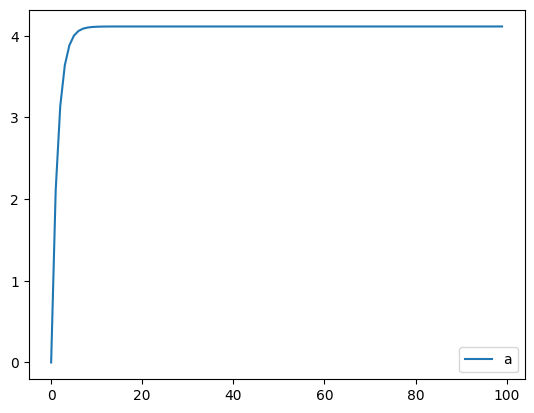

In [12]:
# let's plot as in (a) with our new values 
k_multi = np.linspace(0, 99, 100)

x_multi = np.zeros(101)
for i, k in enumerate(k_multi):
    xk = x_multi[i]
    x_multi[i+1] = f(a_e, xk, b_e, 1)
x_multi = np.array([x for x in x_multi[:-1]])
plt.plot(k_multi, x_multi, label=str(a))
plt.legend()

# Acknowledgment
Work in this repository and with associated assignments and projects may be adapted or copied from similar files used in my prior academic and industry work (e.g., using a LaTeX file or Dockerfile as a starting point). Those files and any other work in this repository may have been developed with the help of LLM's like ChatGPT. For example, to provide context, answer questions, refine writing, understand function call syntax, and assist with repetitive tasks. In these cases, deliverables and associated work reflect my best efforts to optimize my learning and demonstrate my capacity, while using available resources and LLM's to facilitate the process.


[ChatGPT Conversation](https://chatgpt.com/share/68fbf392-ef34-8003-b24d-6bad7f782127)